## Cell type prediction by GDR

In this tutorial, we use a reference dataset to predict the cell type annotations of the query dataset. The cell type annotations of the query dataset are known, therefore our predictions can be verified and checked for accuracy.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import logging
from matplotlib import rcParams
import sys
from sklearn.metrics import f1_score
import warnings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# To modify the default figure size, use rcParams.
sc.set_figure_params(dpi=80,dpi_save=300, color_map='viridis',facecolor='white')
rcParams['figure.figsize'] = 5, 5
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.10.3 anndata==0.10.8 umap==0.5.7 numpy==1.26.4 scipy==1.13.0 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.5 louvain==0.8.2 pynndescent==0.5.13


In [4]:
path = '/home/vas744/Analysis/Python/Packages/PIASO'
sys.path.append(path)
path = '/home/vas744/Analysis/Python/Packages/COSG'
sys.path.append(path)
import piaso

/home/vas744/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


### Load the data

#### Load the reference dataset

We will use the 20k subsampled version of the Seattle Alzheimer’s Disease Brain Cell Atlas (SEA-AD) project dataset described in detail in [Gabitto et. al. (2024)](../references.html#cell1), as the reference dataset. We will be using the scRNA-seq data from the dataset in this tutorial. Please refer to the [Introduction](./PIASO_tutorial.html) tutorial to learn more about how it was preprocessed and normalized.

Download the subsampled, pre-processed dataset from Google Drive: https://drive.google.com/file/d/1pDBIgPvEO-sBuIMEhrvVhnf7tfU7H6Xy/view?usp=drive_link

The original data is available on https://portal.brain-map.org/explore/seattle-alzheimers-disease

In [5]:
data_dir = "/n/scratch/users/v/vas744/Data/Public/PIASO"

In [6]:
!/home/vas744/Software/gdrive files download --overwrite --destination {data_dir} 1pDBIgPvEO-sBuIMEhrvVhnf7tfU7H6Xy

Successfully downloaded SEA-AD_RNA_MTG_subsample_excludeReference_20k_piaso_preprocessed.h5ad


In [6]:
ref_adata=sc.read(data_dir + '/SEA-AD_RNA_MTG_subsample_excludeReference_20k_piaso_preprocessed.h5ad')

ref_adata

AnnData object with n_obs × n_vars = 20000 × 36601
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in mont

#### Load the query dataset

We will use a pre-processed Great Apes RNASeq data, particularly the human data subset as the query dataset for predicting cell types in this tutorial.

Download the dataset from: https://drive.google.com/file/d/1nF0iRTGFFQcEcM6hYcPptiYkxs65k2p4/view?usp=drive_link

In [8]:
!/home/vas744/Software/gdrive files download --overwrite --destination {data_dir} 1nF0iRTGFFQcEcM6hYcPptiYkxs65k2p4

Successfully downloaded GreatApesMTG_RNA_integrated_raw_onlyOrthogonal_gdr_humanSubset_aibs.h5ad


In [7]:
aibs_query_adata = sc.read(data_dir + "/GreatApesMTG_RNA_integrated_raw_onlyOrthogonal_gdr_humanSubset_aibs.h5ad")
aibs_query_adata

AnnData object with n_obs × n_vars = 76560 × 14346
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_id', 'dataset', 'donor', 'species', 'tech', 'species_tech', 'neighborhood', 'layer', 'cluster', 'cluster_color', 'cross_species_cluster', 'cross_species_cluster_color', 'sex', 'donor_color', 'subclass', 'subclass_color', 'class', 'UMAP_1', 'UMAP_2', 'batch', 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pct_counts_ribo', 'Leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'Leiden_colors', 'Sample_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'species_tech_colors', 'subclass_colors', 'umap'
    obsm: 'X_gdr', 'X_gdr_harmony', 'X_svd', 'X_umap', 'X_umap_gdr', 'X_umap_gdr_harmony', 'X_umap_published'
    layers: 'log1p', 'raw'
    obsp: 'connectivities', 'distances'

### Visualize with UMAPs

Reorder the query dataset categories to match the reference dataset categories

In [8]:
categories = ['Astrocyte', 'Chandelier', 'Endothelial', 'L2/3 IT', 'L4 IT', 'L5 ET', 'L5 IT',
              'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Lamp5 Lhx6',
              'Microglia-PVM', 'OPC', 'Oligodendrocyte', 'Pax6', 'Pvalb', 'Sncg', 'Sst',
              'Sst Chodl', 'VLMC', 'Vip']
aibs_query_adata.obs['subclass'] = aibs_query_adata.obs['subclass'].cat.rename_categories(categories)

In [9]:
aibs_query_adata.obs['subclass']=aibs_query_adata.obs['subclass'].astype('category')
aibs_query_adata.obs['subclass']=aibs_query_adata.obs['subclass'].cat.reorder_categories(ref_adata.obs['Subclass'].cat.categories)

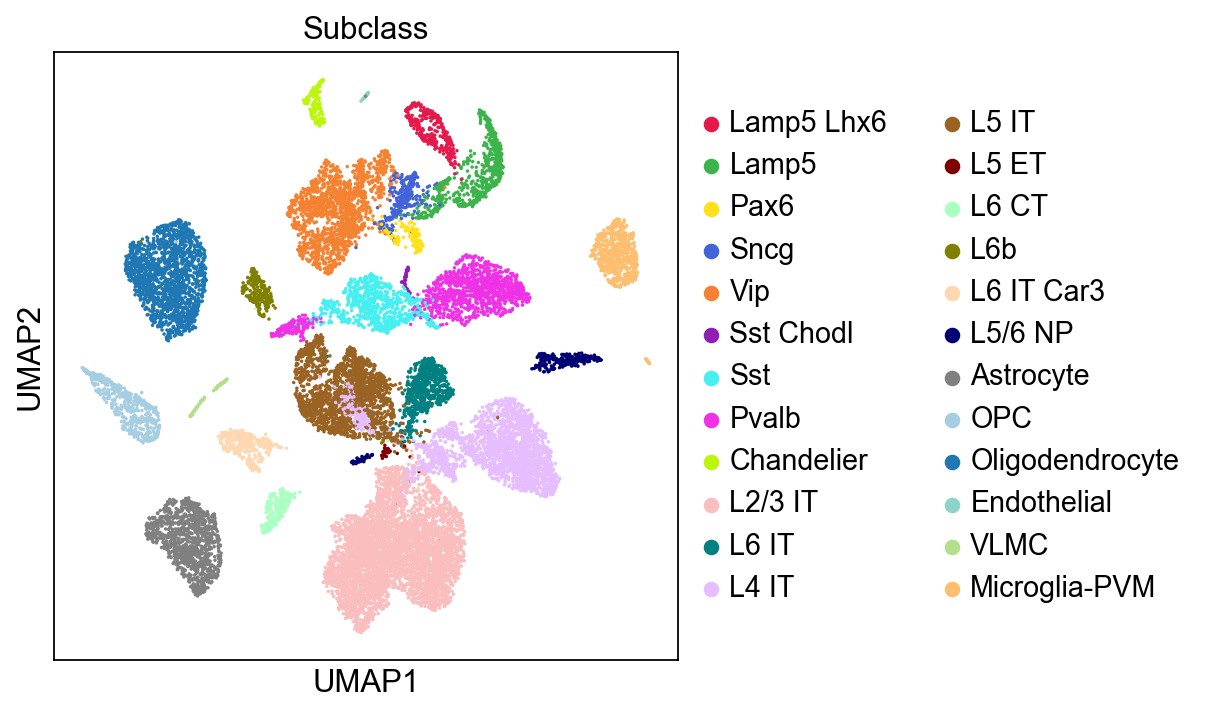

In [10]:
sc.pl.umap(ref_adata,
           color=['Subclass'],
           palette=piaso.pl.color.d_color4,
           ncols=1,
           size=10,
           frameon=True)

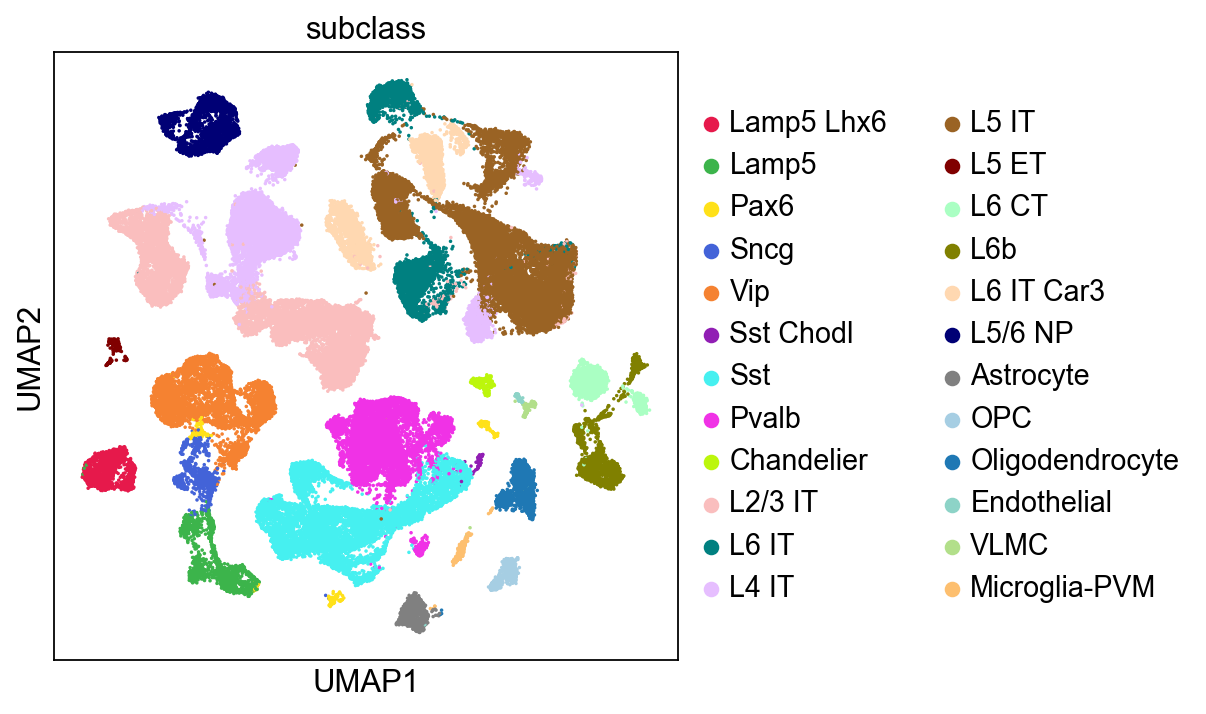

In [11]:
sc.pl.umap(aibs_query_adata,
           color=['subclass'],
           palette=piaso.pl.color.d_color4,
           ncols=1,
           size=10,
           frameon=True)

### Cluster the query data

In [12]:
%%time
sc.tl.leiden(aibs_query_adata,resolution=0.2,key_added='Leiden',flavor="igraph",n_iterations=-1)

running Leiden clustering
    finished: found 26 clusters and added
    'Leiden', the cluster labels (adata.obs, categorical) (0:00:03)
CPU times: user 2.82 s, sys: 253 ms, total: 3.07 s
Wall time: 3.05 s


In [13]:
logging.getLogger('matplotlib.font_manager').disabled = True

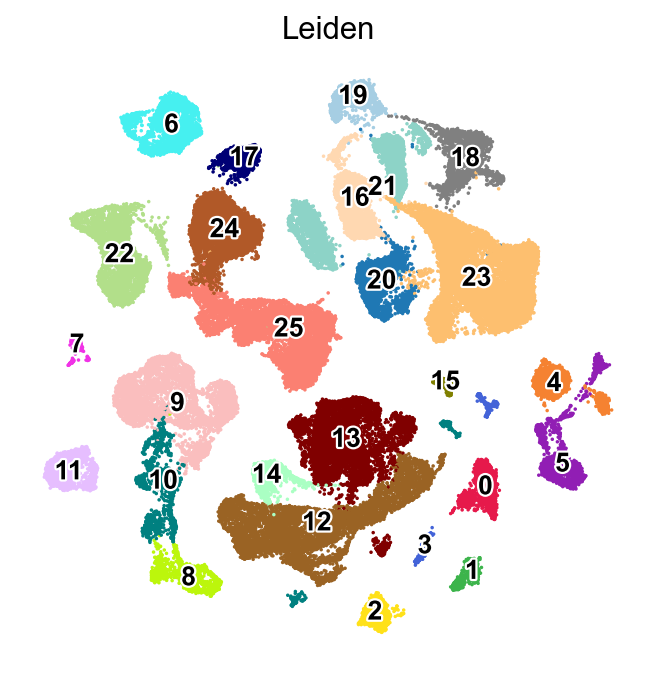

In [14]:
sc.pl.umap(aibs_query_adata,
           color=['Leiden'],
           palette=piaso.pl.color.d_color4,
           legend_fontsize=12,
           legend_fontoutline=2,
           legend_loc='on data',
           ncols=1,
           size=10,
           frameon=False)

### Predict cell types by GDR

In [15]:
piaso.tl.predictCellTypeByGDR(
    aibs_query_adata,
    ref_adata,
    layer = 'log1p',
    layer_reference = 'log1p',
    reference_groupby  = 'Subclass',
    query_groupby = 'Leiden',
    mu = 10.0,
    n_genes= 15,
    return_integration = False,
    use_highly_variable = True,
    n_highly_variable_genes = 5000,
    n_svd_dims = 50,
    resolution= 1.0,
    scoring_method= None,
    key_added= None,
    verbosity= 0,
)

Running GDR for the query dataset and the reference dataset:
GDR embeddings saved to adata.obsm['X_gdr']


2025-03-13 17:56:06,884 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-13 17:56:17,410 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-13 17:56:18,858 - harmonypy - INFO - Iteration 1 of 10
2025-03-13 17:57:19,554 - harmonypy - INFO - Iteration 2 of 10
2025-03-13 17:58:25,833 - harmonypy - INFO - Iteration 3 of 10
2025-03-13 17:58:58,705 - harmonypy - INFO - Iteration 4 of 10
2025-03-13 17:59:24,916 - harmonypy - INFO - Iteration 5 of 10
2025-03-13 17:59:46,990 - harmonypy - INFO - Converged after 5 iterations


Predicting cell types:
All finished. The predicted cell types are saved as `CellTypes_gdr` in adata.obs.


Reorder the query dataset categories to match the reference dataset categories

In [16]:
aibs_query_adata.obs['CellTypes_gdr']=aibs_query_adata.obs['CellTypes_gdr'].astype('category')
aibs_query_adata.obs['CellTypes_gdr']=aibs_query_adata.obs['CellTypes_gdr'].cat.reorder_categories(aibs_query_adata.obs['subclass'].cat.categories)

We can now visualize the predicted cell types from GDR using a UMAP and compare them with the UMAP of the true cell types.

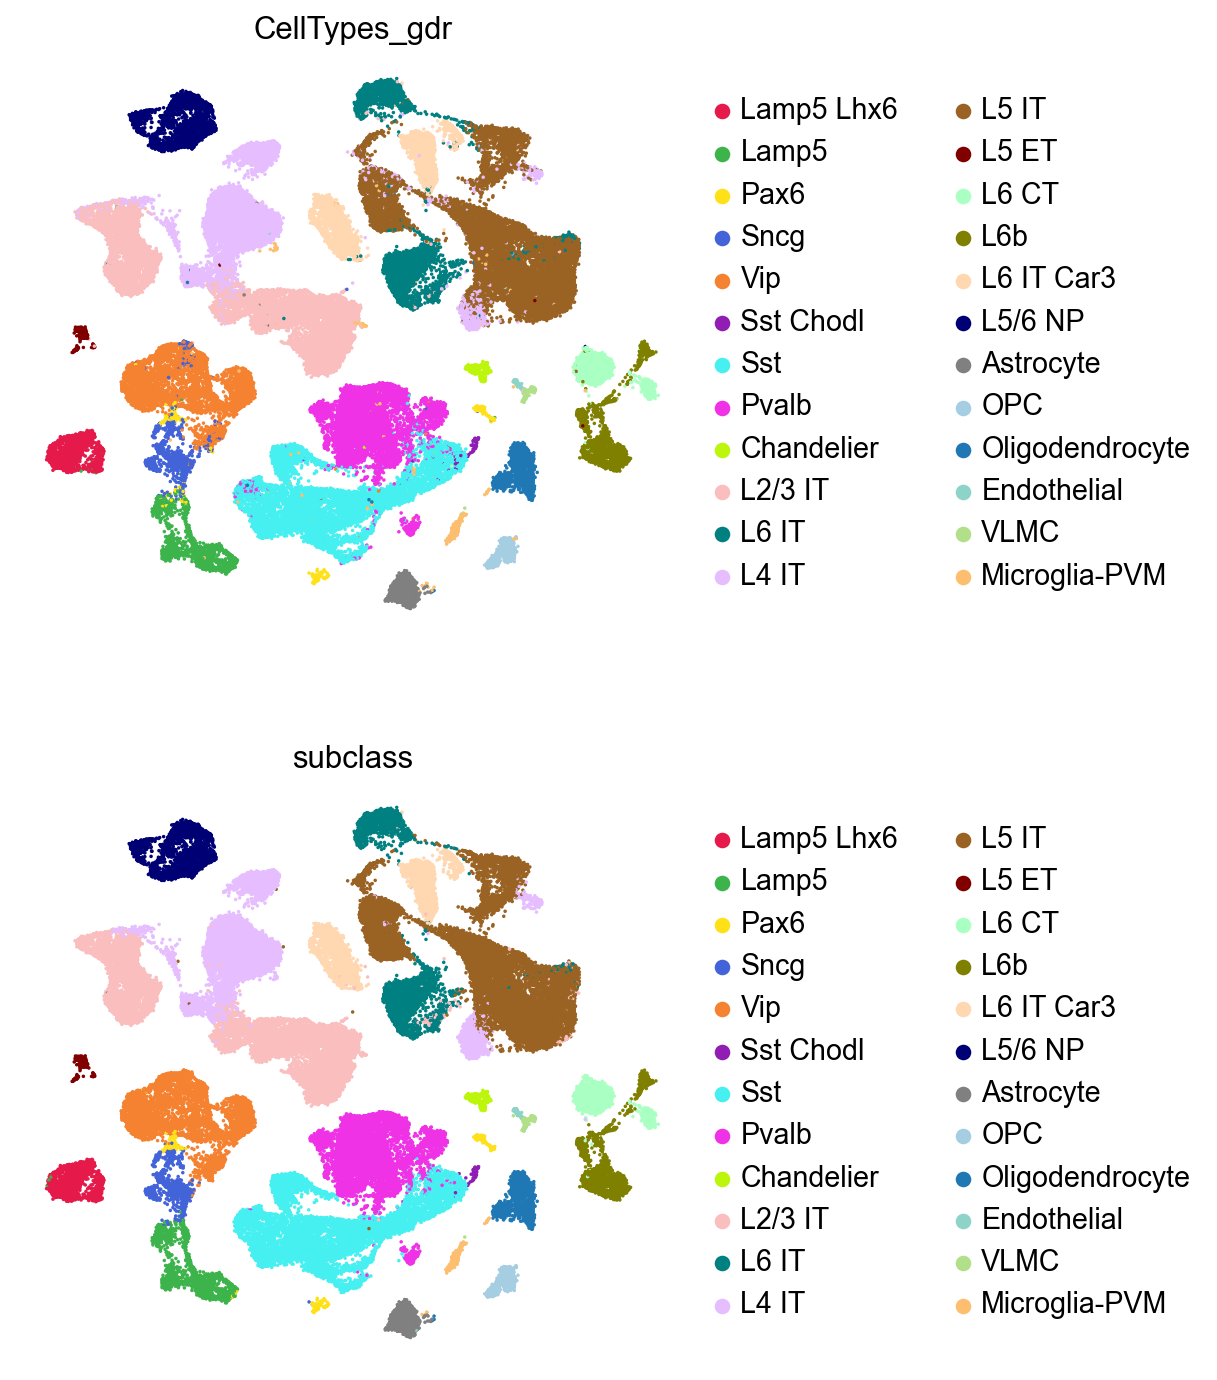

In [17]:
sc.pl.embedding(aibs_query_adata,
                basis='X_umap',
                color=['CellTypes_gdr', 'subclass'],
                palette=piaso.pl.color.d_color4,
                cmap=piaso.pl.color.c_color3,
                ncols=1,
                size=10,
                frameon=False)

Since we know the real subclass of the test data, we can test the performance of predictCellTypeByGDR by comparing predicted celltypes and true subclasses.

In [18]:
confusion_matrix = metrics.confusion_matrix(aibs_query_adata.obs['subclass'].values, aibs_query_adata.obs['CellTypes_gdr'].values)
confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=aibs_query_adata.obs['subclass'].cat.categories, index=aibs_query_adata.obs['subclass'].cat.categories)

In [19]:
normalized_cf_matrix_df = confusion_matrix_df/confusion_matrix_df.sum(axis=0)

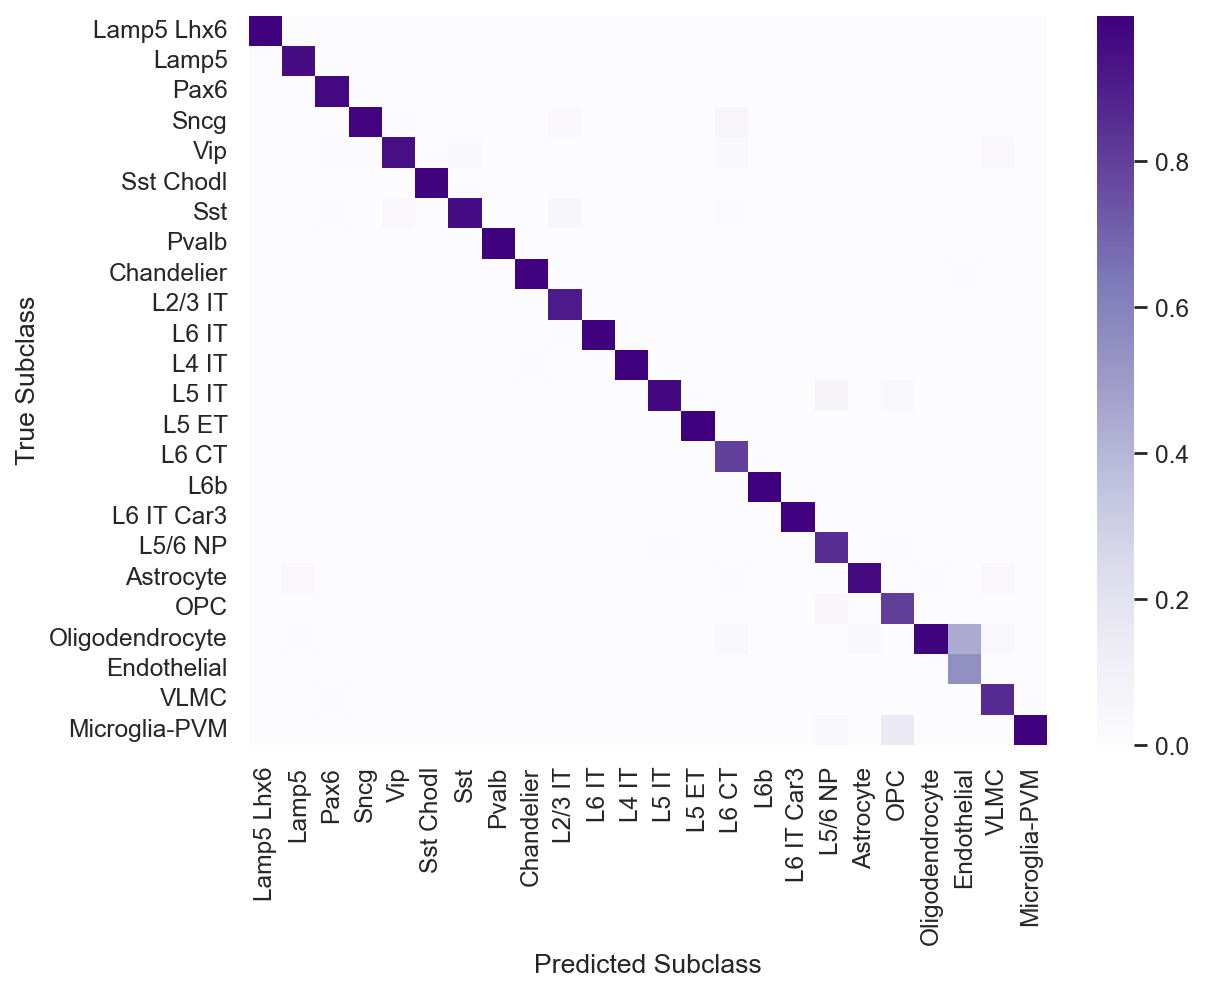

In [20]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(rc={'figure.figsize':(8, 6)})
sns.heatmap(normalized_cf_matrix_df,
            cmap="Purples",
            xticklabels=True,
            yticklabels=True)
plt.xlabel("Predicted Subclass")
plt.ylabel("True Subclass")
plt.show()

In [21]:
piaso_f1_score=np.round(f1_score(aibs_query_adata.obs['subclass'], aibs_query_adata.obs['CellTypes_gdr'], average='micro'), decimals=3)
print(f"The Micro F1 score for PIASO prediction: {piaso_f1_score}")
piaso_f1_score=np.round(f1_score(aibs_query_adata.obs['subclass'], aibs_query_adata.obs['CellTypes_gdr'], average='macro'), decimals=3)
print(f"The Macro F1 score for PIASO prediction: {piaso_f1_score}")

The Micro F1 score for PIASO prediction: 0.967
The Macro F1 score for PIASO prediction: 0.951
